### ZVAR Tools - Data Sources

In [1]:
from zvartools.data import LocalDataSource
from zvartools.lightcurves import freq_grid
from zvartools.plot import plot_folded_lightcurve, plot_periodicity

In [2]:
local_lightcurve_path = "data/test/lightcurves"
local_period_path = "data/test/periods"

data_source = LocalDataSource(local_lightcurve_path, local_period_path, verbose=True)

In [3]:
fields = [648]

candidates = data_source.load_variability_candidate_dataset(
    fields=fields, path="../data/demo_data/candidates"
)

print(f"Loaded {len(candidates)} candidates")

Loaded 2271 candidates


In [7]:
# let's select a subset based on it's Gaia BP-RP color, period around 20 hours and detected in r-band
giant_candidates = [
    candidate
    for candidate in candidates
    if (
        candidate.gaia.BP_RP is not None
        and candidate.gaia.BP_RP > 1.0
        and candidate.gaia.MG is not None
        and candidate.gaia.MG < 3.0
        and candidate.period is not None
        and candidate.period >= 19.0
        and candidate.period <= 20.0
        and candidate.band == "r"
    )
]
print(f"Selected {len(giant_candidates)} giant candidates")

Selected 1 giant candidates


In [8]:
lightcurves = data_source.get_candidates_lightcurves(giant_candidates)

Last but not least, you can plot the lightcurves folded on their period:

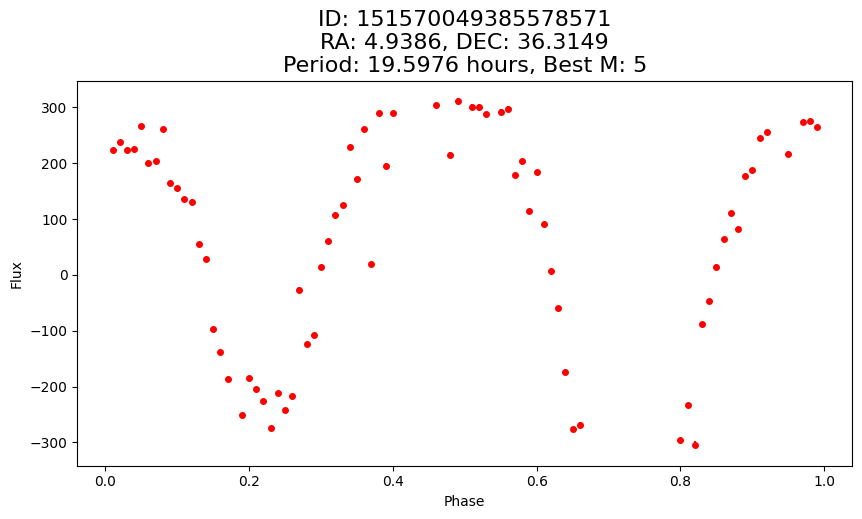

In [12]:
for cand in giant_candidates:
    lc = lightcurves[cand.psid]
    try:
        plot_folded_lightcurve(cand, lc, figsize=(10, 5), bins=100)
    except Exception as e:
        print(f"Error plotting candidate {cand.psid}: {e}")
        continue

### Computing periods

In [10]:
import fpw
import numpy as np

In [16]:
candidate = giant_candidates[-1]
phot = lightcurves[candidate.psid].copy()
print(f"Number of data points: {len(phot[0])}")
phot = phot[:, phot[3] == 2]
print(f"Number of data points in r band: {len(phot[0])}")

if fpw is None:
    raise ImportError(
        "Could not import fpw. You will not be able to use the fpw module."
    )

f_grid = freq_grid(phot[0])

# we make sure all arrays are C-contiguous
time, flux, flux_err = [np.ascontiguousarray(x) for x in phot[:3]]

fpw_pgram = fpw.run_fpw(time, flux, flux_err, f_grid, 5)  # where 5 is the bin size
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = (
    1 / f_grid[np.argmax(fpw_pgram)] / 3600 / 24
)  # best period in days, where the power is maximized

print(f"Best FPW period: {best_period / 24:.4f} days")

Number of data points: 280
Number of data points in r band: 280
Best FPW period: 0.0340 days


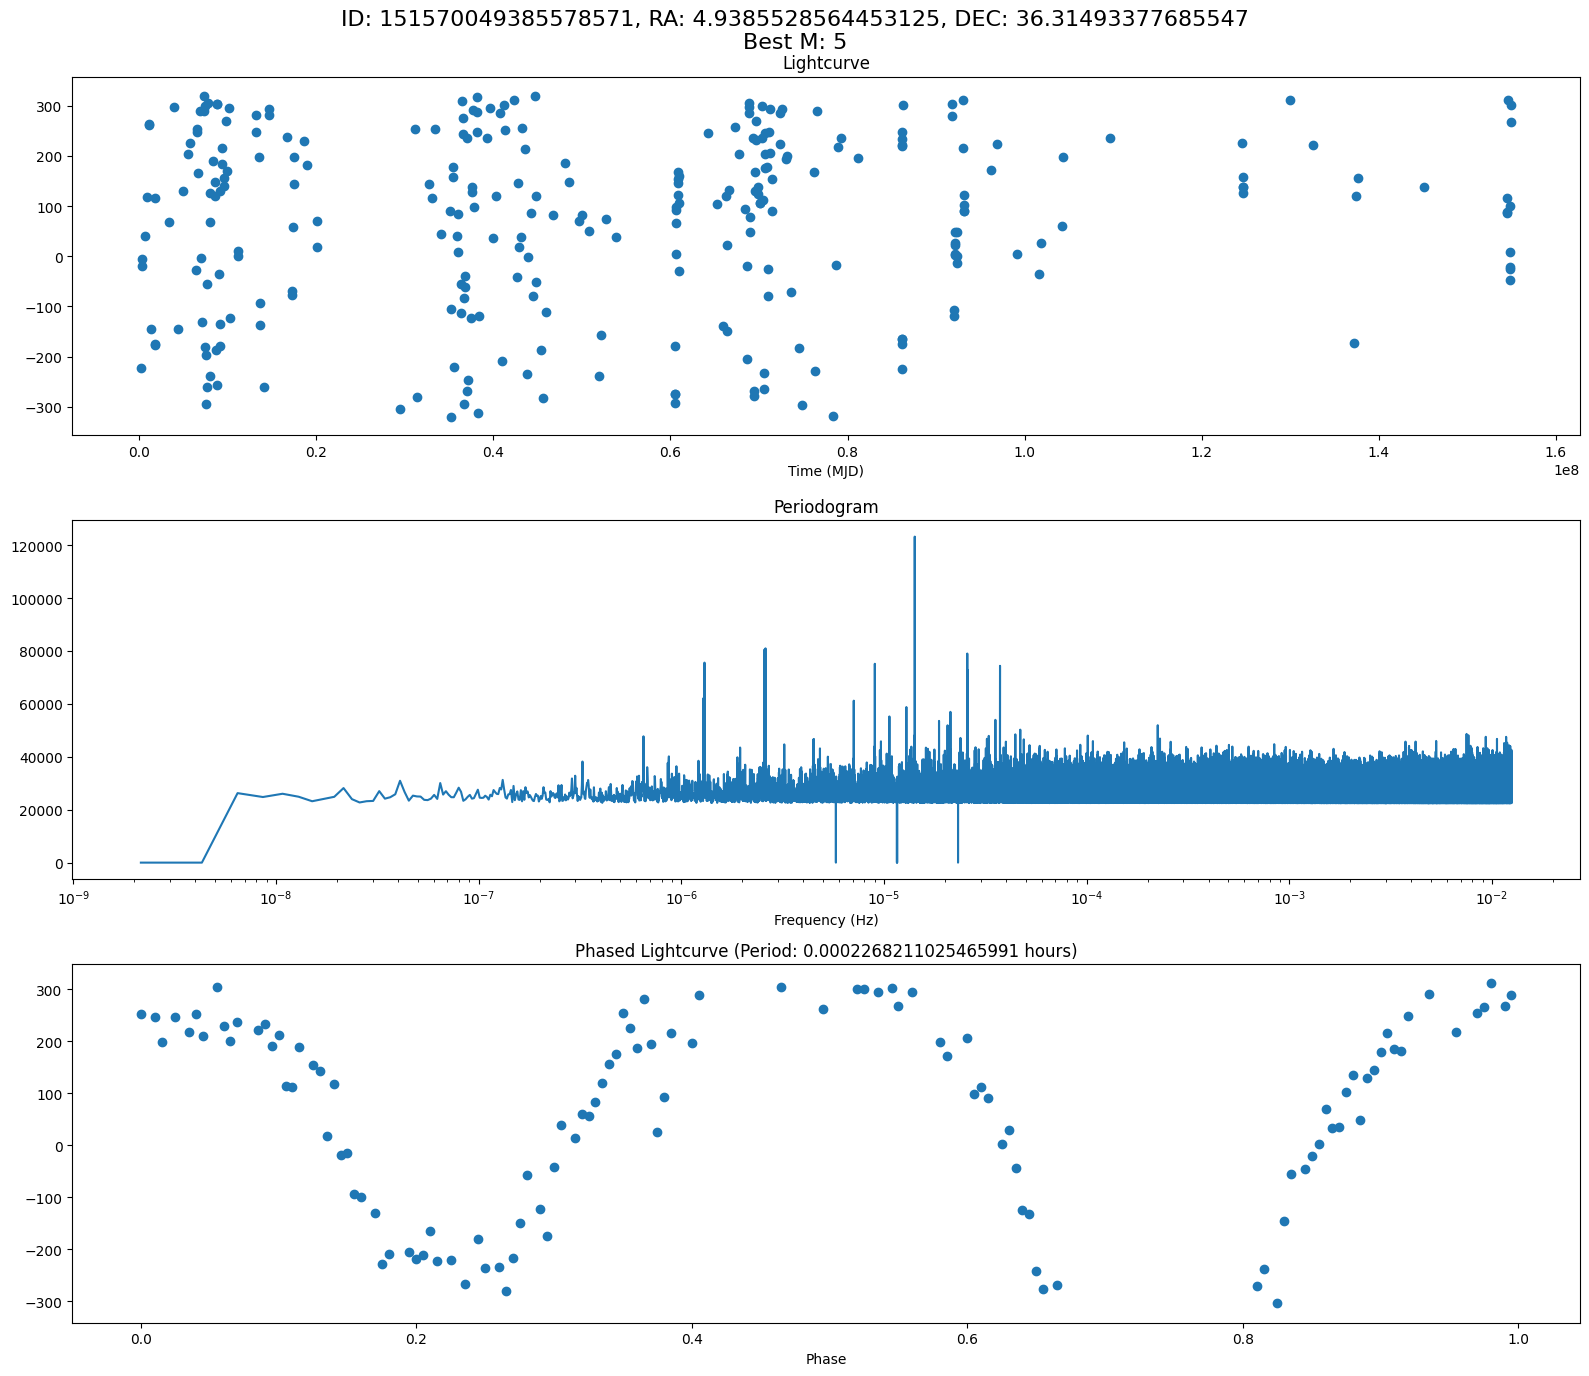

In [19]:
plot_periodicity(
    candidate, phot, fpw_pgram, best_period, show_plot=True, figsize=(16, 14), bins=200
)